## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [28]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

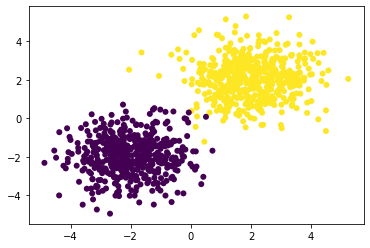

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:

net = Sequential()
net.add(Linear(2, 4))
net.add(SoftPlus())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

criterion = ClassNLLCriterion()



# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())
# print(net)

Linear 2 -> 4
SoftPlus
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
def sgd_momentum(x, dx, config, state):
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

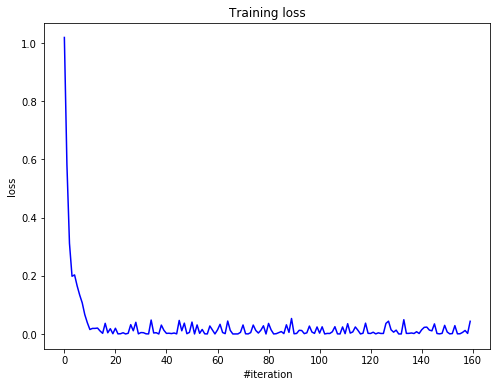

Current loss: 0.043650


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [200]:
import mnist2
X_train, y_train, X_val, y_val, X_test, y_test = mnist2.load_dataset()

One-hot encode the labels first.

In [201]:
def one_hot(y):
    u = np.unique(y).size
    oh = np.zeros((y.size, u))
    oh[range(y.size), y] = 1
    return oh

In [202]:
y_train_orig, y_val_orig, y_test_orig = y_train, y_val, y_test
y_train, y_val, y_test = one_hot(y_train), one_hot(y_val), one_hot(y_test)

In [203]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [204]:
def train(X, y, net, n_epoch=20, batch_size=500, learning_rate=0.1, momentum=0.9):
    
    loss_epoch_history = []
    for i in tqdm(range(n_epoch)):
        
        loss_history = []
        for x_batch, y_batch in get_batches((X, y), batch_size):
            # Optimizer params
            optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
            optimizer_state = {}
            
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            loss_history.append(loss)
#             print('Current loss: %f' % loss_history)
        loss_epoch_history.append(np.mean(loss_history))
    return loss_epoch_history

In [205]:
def make_clf_net(activation):
    net = Sequential()
    net.add(Linear(28*28, 40))
    net.add(activation())
    net.add(Linear(40, 10))
    net.add(LogSoftMax())
    return net

In [206]:
EPOCH_COUNT = 20

In [207]:
activations = [ReLU, LeakyReLU, ELU, SoftPlus]
# activations = (ReLU, LeakyReLU)

#This takes very long to calculate
all_losses = []
for activation in activations:
    net = make_clf_net(activation)
    print(net)
    
    losses = train(X_train.reshape(len(X_train), -1), y_train, net, n_epoch=EPOCH_COUNT)
    print("Loss :", losses)
    all_losses.append(losses)






  0%|                                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Linear 784 -> 40
ReLU
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:08<02:34,  8.16s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:16<02:26,  8.13s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:24<02:16,  8.04s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:31<02:07,  7.95s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:39<01:58,  7.92s/it]




 30%|█████████████████████████

Loss : [1.2396128217012405, 0.5014348806735893, 0.40004706297290327, 0.35921730094347365, 0.3348288618774165, 0.31685317650668726, 0.30295884005784396, 0.2908305626140274, 0.2802041198593048, 0.2702876728301398, 0.2614357285491691, 0.25340004718619763, 0.24576992838238876, 0.2384942325743063, 0.23197090886758417, 0.22575763231870347, 0.21995322417417154, 0.21431637520802735, 0.20950994167850281, 0.20459378901418568]
Linear 784 -> 40
LeakyReLU
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:07<02:24,  7.60s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:15<02:18,  7.68s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:23<02:13,  7.86s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:31<02:06,  7.93s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:39<01:59,  7.95s/it]




 30%|█████████████████████████

Loss : [1.250437519213933, 0.501934828564862, 0.40018663102652646, 0.35938701039841175, 0.3358296693576143, 0.3181579160402716, 0.3045773663576468, 0.2929477529258845, 0.28274853348371526, 0.2734972892387195, 0.26499873602232976, 0.25727782044072894, 0.2504939858430086, 0.24425835147840846, 0.23821031646902427, 0.23245220459404162, 0.2271729172317939, 0.222415525219216, 0.2172906386874967, 0.21280400133849592]
Linear 784 -> 40
ELU
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:07<02:15,  7.14s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:14<02:07,  7.09s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:21<02:02,  7.19s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:29<01:59,  7.47s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:37<01:54,  7.61s/it]




 30%|█████████████████████████

Loss : [1.1541996817435318, 0.48520872259203385, 0.39450238787180475, 0.3587983640814199, 0.33852239677340895, 0.3239282526581537, 0.3135050825574525, 0.3042461560755932, 0.29627422974772943, 0.2890591071384965, 0.28172455142603126, 0.27504142801764675, 0.26844453266571994, 0.26206800881472403, 0.2556662506758263, 0.2499180061923077, 0.24394263003692143, 0.2385851473434945, 0.23298434228656562, 0.2280229571132249]
Linear 784 -> 40
SoftPlus
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:07<02:31,  8.00s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:16<02:24,  8.02s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:23<02:15,  7.94s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:30<02:02,  7.66s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:37<01:51,  7.46s/it]




 30%|█████████████████████████

Loss : [1.5829754635315183, 0.5952968358815725, 0.436427015404182, 0.3846505784530047, 0.3575610037122937, 0.3411837596683492, 0.327878157572717, 0.318048908985723, 0.3104352273518436, 0.30401985378391555, 0.29790434886707085, 0.2927022316907218, 0.2878010211198692, 0.2828663754326113, 0.2783763795880523, 0.27485667342061343, 0.2693652339297087, 0.265388670863349, 0.2607412716628896, 0.25673345214469145]


In [208]:
#Plot losses
def plot_losses(all_losses, labels, title = ''):
    plt.figure(figsize = (15,10))
    for losses, label in zip(all_losses, labels):
        plt.plot(losses, label = label)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title(title)
    plt.gca().set_yscale('log')
    plt.grid()
    plt.legend()
    plt.show()


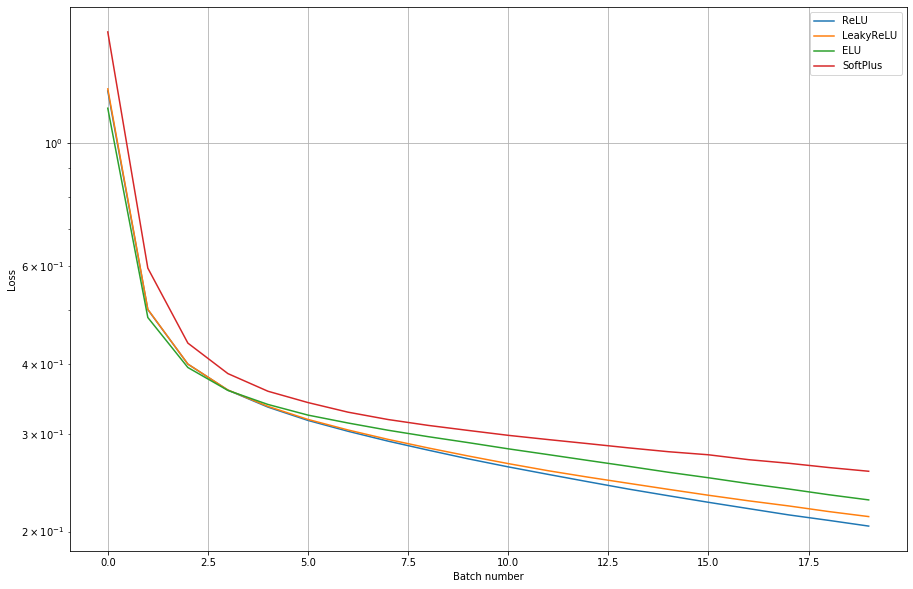

In [209]:
plot_losses(all_losses, (act.__name__ for act in activations))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [210]:
# Your code goes here. ################################################
def make_clf_net(is_bach_norm):
    net = Sequential()
    net.add(Linear(28*28, 40))
    net.add(ELU())
    if is_bach_norm :
        net.add(BatchNormalization())
    net.add(Linear(40, 10))
    net.add(LogSoftMax())
    return net

In [211]:
net = make_clf_net(is_bach_norm = False)
print(net)
losses = train(X_train.reshape(len(X_train), -1), y_train, net, n_epoch=EPOCH_COUNT)
activations.append(Linear)
all_losses.append(losses)


net = make_clf_net(is_bach_norm = True)
print(net)
losses = train(X_train.reshape(len(X_train), -1), y_train, net, n_epoch=EPOCH_COUNT)
activations.append(BatchNormalization)

all_losses.append(losses)






  0%|                                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Linear 784 -> 40
ELU
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:08<02:45,  8.68s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:17<02:37,  8.72s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:26<02:28,  8.75s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:35<02:20,  8.77s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:43<02:11,  8.76s/it]




 30%|█████████████████████████

Linear 784 -> 40
ELU
BatchNormalization
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:08<02:45,  8.70s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:17<02:36,  8.67s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:26<02:28,  8.76s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:34<02:19,  8.73s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:43<02:10,  8.68s/it]




 30%|█████████████████████████

In [212]:
activations

[__main__.ReLU,
 __main__.LeakyReLU,
 __main__.ELU,
 __main__.SoftPlus,
 __main__.Linear,
 __main__.BatchNormalization]

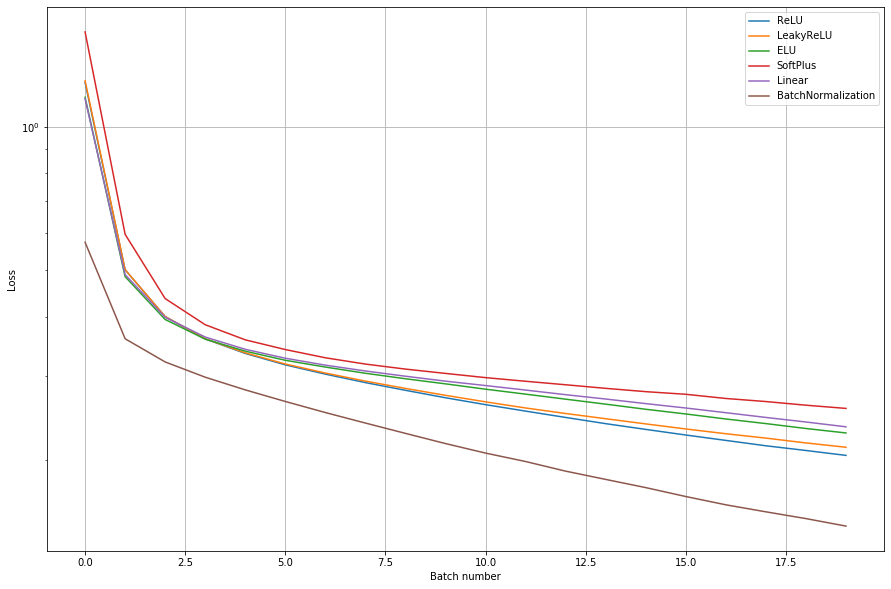

In [213]:
plot_losses(all_losses, (act.__name__ for act in activations))

In [214]:
# Your code goes here. ################################################

In [215]:
def train(X, y, net, n_epoch=20, batch_size=500, learning_rate=0.1, momentum=0.9, optimizer= sgd_momentum , optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}):
    
    loss_epoch_history = []
    for i in tqdm(range(n_epoch)):
        
        loss_history = []
        for x_batch, y_batch in get_batches((X, y), batch_size):
            # Optimizer params
            optimizer_state = {}
            
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            loss_history.append(loss)
#             print('Current loss: %f' % loss_history)
        loss_epoch_history.append(np.mean(loss_history))
    return loss_epoch_history

In [216]:
net = Sequential()
net.add(Linear(28*28, 40))
net.add(ReLU())
net.add(Linear(40, 10))
net.add(LogSoftMax())
print(net)
losses = train(X_train.reshape(len(X_train), -1), y_train, net, n_epoch=EPOCH_COUNT, optimizer = adam_optimizer,
              optimizer_config = {'learning_rate':0.1, 'beta1':0.9, 'beta2':0.999, 'epsilon':10**-7})
activations.append(adam_optimizer)
all_losses.append(losses)


net = Sequential()
net.add(Linear(28*28, 40))
net.add(ReLU())
net.add(Linear(40, 10))
net.add(LogSoftMax())
print(net)
losses = train(X_train.reshape(len(X_train), -1), y_train, net, n_epoch=EPOCH_COUNT, optimizer = sgd_momentum)
activations.append(sgd_momentum)
all_losses.append(losses)






  0%|                                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Linear 784 -> 40
ReLU
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:12<03:56, 12.46s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:26<03:50, 12.80s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:39<03:41, 13.03s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:52<03:26, 12.92s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [01:04<03:09, 12.65s/it]




 30%|█████████████████████████

Linear 784 -> 40
ReLU
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:07<02:29,  7.88s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:15<02:20,  7.83s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:23<02:11,  7.73s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:31<02:04,  7.79s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:39<01:58,  7.90s/it]




 30%|█████████████████████████

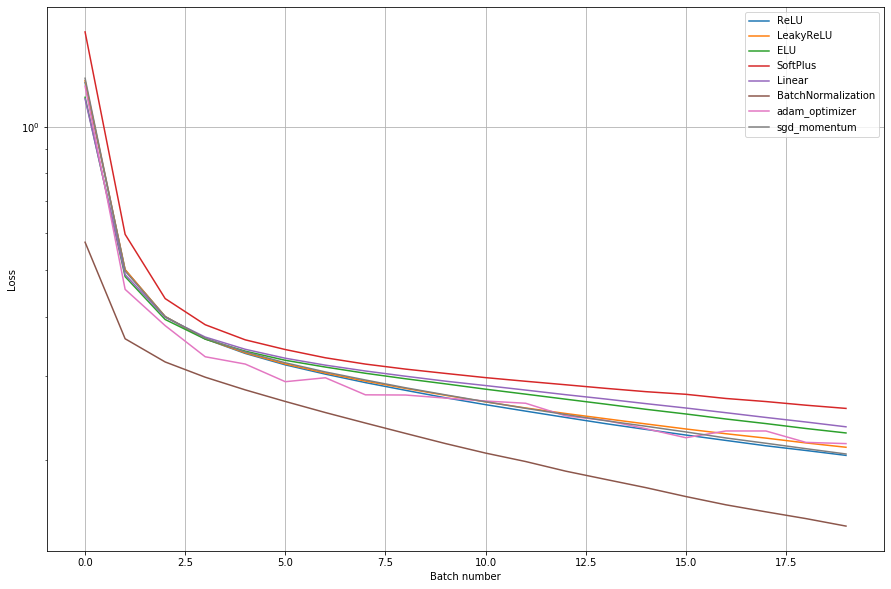

In [217]:
plot_losses(all_losses, (act.__name__ for act in activations))

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [218]:
# # Your answer goes here. ################################################
# Судя по тестам BatchNorm помогает больше всего
# Adam лучше SGD, даже с моментумом
# Из всех активаций предпочитаю ELU

# Время вычисления - понятие относительное, потому что можно абстракно рассуждать, 
# что у BatchNorm есть лишняя операция, что у ELU более сложный градиент, но мы mnist считаем, тут это практически не имеет значения
# На реальных задачах - А нам точно нужны NN? А какая точность от нас требуется?

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [219]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(28*28, 40))
net.add(ELU())
net.add(BatchNormalization())
net.add(Dropout())
net.add(Linear(40, 10))
net.add(LogSoftMax())

net.train()

print(net)

losses = train(X_train.reshape(len(X_train), -1), y_train, net, n_epoch=EPOCH_COUNT, optimizer = adam_optimizer,
              optimizer_config = {'learning_rate':0.1, 'beta1':0.9, 'beta2':0.999, 'epsilon':10**-7})






  0%|                                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Linear 784 -> 40
ELU
BatchNormalization
Dropout
Linear 40 -> 10
LogSoftMax








  5%|███████▌                                                                                                                                                | 1/20 [00:08<02:37,  8.29s/it]




 10%|███████████████▏                                                                                                                                        | 2/20 [00:16<02:27,  8.18s/it]




 15%|██████████████████████▊                                                                                                                                 | 3/20 [00:24<02:17,  8.07s/it]




 20%|██████████████████████████████▍                                                                                                                         | 4/20 [00:32<02:09,  8.07s/it]




 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:40<02:00,  8.04s/it]




 30%|█████████████████████████

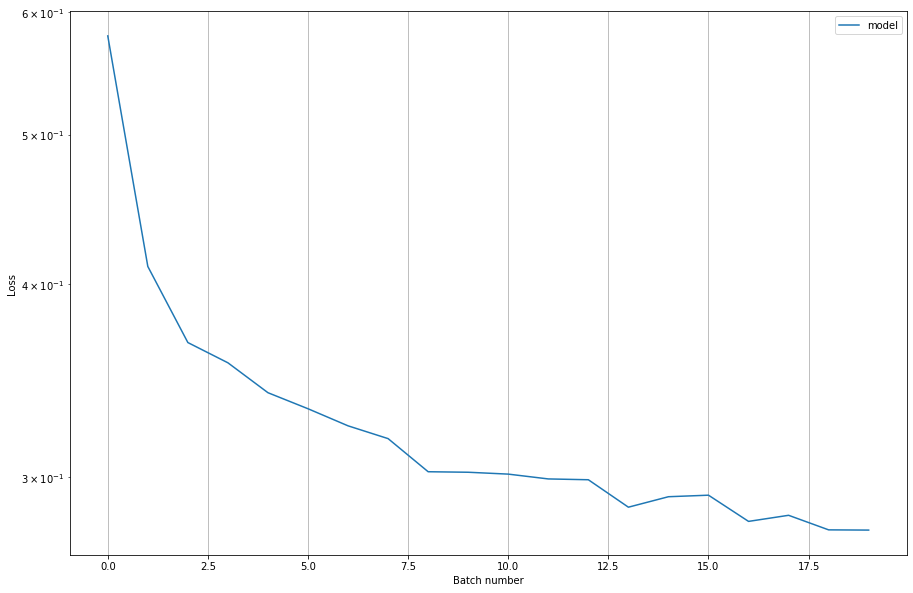

In [220]:
plot_losses([losses],["model"])

In [221]:
net.evaluate()

y_hat = net.forward(X_test.reshape(len(X_test), -1))
acc = np.mean(y_test.argmax(axis=1) == y_hat.argmax(axis=1)) * 100
print("Accuracy of our shiny model is %.f%%" % acc)

Accuracy of our shiny model is 95%


Print here your accuracy on test set. It should be around 90%.

In [222]:
# Your answer goes here. ################################################
# Получилось!
# На самом деле точность около 90% получилась через 2 эпохи и без dropout

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [192]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [193]:
# Your beautiful code here.

class ShinyNN(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, input_shape),
            nn.ELU(),
            nn.BatchNorm1d(input_shape),
            nn.Dropout(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):  
        out = self.model(inp)
        return out

In [194]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'mnist'
mkdir(root_path)

Directory mnist already exists!


In [195]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.MNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.MNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [196]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=500,
                                           shuffle=True,
                                           num_workers=2,)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=500,
                                          shuffle=False,
                                          num_workers=2)

In [197]:
torchsummary.summary(ShinyNN().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
               ELU-3                  [-1, 784]               0
       BatchNorm1d-4                  [-1, 784]           1,568
           Dropout-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 624,858
Trainable params: 624,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.38
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


In [198]:
model = ShinyNN().to(device)

learning_rate = 0.1
num_epochs = 50

opt = torch.optim.Adam(model.parameters(), lr=learning_rate) 
loss_func =  nn.CrossEntropyLoss()  


In [199]:
# Train the model
total_step = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):  
        
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # Backprpagation and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    #Compute Accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
#         print('Accuracy on test images: {} %'.format()
        print ('Epoch [{}/{}], \t Accuracy {}%'.format(epoch+1, num_epochs, accuracy ))






  0%|                                                                                                                                                                | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [100/120], Loss: 0.4936







  2%|███                                                                                                                                                     | 1/50 [00:05<04:27,  5.46s/it]

Epoch [1/50], 	 Accuracy 91.74%
Epoch [2/50], Step [100/120], Loss: 0.3371







  4%|██████                                                                                                                                                  | 2/50 [00:11<04:23,  5.50s/it]

Epoch [2/50], 	 Accuracy 92.25%
Epoch [3/50], Step [100/120], Loss: 0.2502







  6%|█████████                                                                                                                                               | 3/50 [00:16<04:16,  5.47s/it]

Epoch [3/50], 	 Accuracy 93.27%
Epoch [4/50], Step [100/120], Loss: 0.5360







  8%|████████████▏                                                                                                                                           | 4/50 [00:21<04:12,  5.48s/it]

Epoch [4/50], 	 Accuracy 92.42%
Epoch [5/50], Step [100/120], Loss: 0.5683







 10%|███████████████▏                                                                                                                                        | 5/50 [00:27<04:07,  5.49s/it]

Epoch [5/50], 	 Accuracy 92.42%
Epoch [6/50], Step [100/120], Loss: 0.5828







 12%|██████████████████▏                                                                                                                                     | 6/50 [00:33<04:03,  5.53s/it]

Epoch [6/50], 	 Accuracy 91.78%
Epoch [7/50], Step [100/120], Loss: 1.0500







 14%|█████████████████████▎                                                                                                                                  | 7/50 [00:38<04:01,  5.62s/it]

Epoch [7/50], 	 Accuracy 94.13%
Epoch [8/50], Step [100/120], Loss: 0.6197







 16%|████████████████████████▎                                                                                                                               | 8/50 [00:45<04:03,  5.79s/it]

Epoch [8/50], 	 Accuracy 93.8%
Epoch [9/50], Step [100/120], Loss: 0.9472







 18%|███████████████████████████▎                                                                                                                            | 9/50 [00:51<04:00,  5.87s/it]

Epoch [9/50], 	 Accuracy 93.83%
Epoch [10/50], Step [100/120], Loss: 1.2091







 20%|██████████████████████████████▏                                                                                                                        | 10/50 [00:57<03:56,  5.92s/it]

Epoch [10/50], 	 Accuracy 93.66%
Epoch [11/50], Step [100/120], Loss: 0.8808







 22%|█████████████████████████████████▏                                                                                                                     | 11/50 [01:03<03:52,  5.97s/it]

Epoch [11/50], 	 Accuracy 94.07%
Epoch [12/50], Step [100/120], Loss: 0.7776







 24%|████████████████████████████████████▏                                                                                                                  | 12/50 [01:09<03:49,  6.04s/it]

Epoch [12/50], 	 Accuracy 94.6%
Epoch [13/50], Step [100/120], Loss: 1.0298







 26%|███████████████████████████████████████▎                                                                                                               | 13/50 [01:15<03:44,  6.06s/it]

Epoch [13/50], 	 Accuracy 94.4%
Epoch [14/50], Step [100/120], Loss: 1.1733







 28%|██████████████████████████████████████████▎                                                                                                            | 14/50 [01:21<03:38,  6.07s/it]

Epoch [14/50], 	 Accuracy 94.21%
Epoch [15/50], Step [100/120], Loss: 0.8819







 30%|█████████████████████████████████████████████▎                                                                                                         | 15/50 [01:27<03:32,  6.07s/it]

Epoch [15/50], 	 Accuracy 95.0%
Epoch [16/50], Step [100/120], Loss: 1.0902







 32%|████████████████████████████████████████████████▎                                                                                                      | 16/50 [01:34<03:31,  6.22s/it]

Epoch [16/50], 	 Accuracy 93.02%
Epoch [17/50], Step [100/120], Loss: 0.5051







 34%|███████████████████████████████████████████████████▎                                                                                                   | 17/50 [01:40<03:28,  6.33s/it]

Epoch [17/50], 	 Accuracy 94.58%
Epoch [18/50], Step [100/120], Loss: 0.4708







 36%|██████████████████████████████████████████████████████▎                                                                                                | 18/50 [01:47<03:20,  6.27s/it]

Epoch [18/50], 	 Accuracy 95.25%
Epoch [19/50], Step [100/120], Loss: 0.5746







 38%|█████████████████████████████████████████████████████████▍                                                                                             | 19/50 [01:53<03:12,  6.21s/it]

Epoch [19/50], 	 Accuracy 95.14%
Epoch [20/50], Step [100/120], Loss: 0.4664







 40%|████████████████████████████████████████████████████████████▍                                                                                          | 20/50 [01:59<03:03,  6.13s/it]

Epoch [20/50], 	 Accuracy 95.25%
Epoch [21/50], Step [100/120], Loss: 0.6147







 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 21/50 [02:05<02:57,  6.13s/it]

Epoch [21/50], 	 Accuracy 94.82%
Epoch [22/50], Step [100/120], Loss: 0.8993







 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 22/50 [02:11<02:49,  6.04s/it]

Epoch [22/50], 	 Accuracy 95.19%
Epoch [23/50], Step [100/120], Loss: 1.3030







 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 23/50 [02:16<02:41,  5.99s/it]

Epoch [23/50], 	 Accuracy 95.08%
Epoch [24/50], Step [100/120], Loss: 0.9561







 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 24/50 [02:22<02:34,  5.94s/it]

Epoch [24/50], 	 Accuracy 95.32%
Epoch [25/50], Step [100/120], Loss: 0.9657







 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 25/50 [02:28<02:27,  5.91s/it]

Epoch [25/50], 	 Accuracy 94.75%
Epoch [26/50], Step [100/120], Loss: 1.7623







 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 26/50 [02:34<02:22,  5.94s/it]

Epoch [26/50], 	 Accuracy 95.53%
Epoch [27/50], Step [100/120], Loss: 0.8813







 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 27/50 [02:40<02:15,  5.90s/it]

Epoch [27/50], 	 Accuracy 95.07%
Epoch [28/50], Step [100/120], Loss: 0.3694







 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 28/50 [02:46<02:09,  5.90s/it]

Epoch [28/50], 	 Accuracy 96.15%
Epoch [29/50], Step [100/120], Loss: 1.1237







 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 29/50 [02:52<02:03,  5.89s/it]

Epoch [29/50], 	 Accuracy 95.64%
Epoch [30/50], Step [100/120], Loss: 0.2014







 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/50 [02:57<01:57,  5.87s/it]

Epoch [30/50], 	 Accuracy 95.9%
Epoch [31/50], Step [100/120], Loss: 1.0720







 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 31/50 [03:03<01:51,  5.89s/it]

Epoch [31/50], 	 Accuracy 96.04%
Epoch [32/50], Step [100/120], Loss: 0.4674







 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 32/50 [03:10<01:48,  6.04s/it]

Epoch [32/50], 	 Accuracy 95.55%
Epoch [33/50], Step [100/120], Loss: 1.1191







 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 33/50 [03:16<01:43,  6.07s/it]

Epoch [33/50], 	 Accuracy 95.66%
Epoch [34/50], Step [100/120], Loss: 1.4339







 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 34/50 [03:22<01:36,  6.01s/it]

Epoch [34/50], 	 Accuracy 96.26%
Epoch [35/50], Step [100/120], Loss: 1.1522







 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 35/50 [03:28<01:29,  5.96s/it]

Epoch [35/50], 	 Accuracy 95.76%
Epoch [36/50], Step [100/120], Loss: 1.2045







 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 36/50 [03:34<01:23,  5.94s/it]

Epoch [36/50], 	 Accuracy 96.11%
Epoch [37/50], Step [100/120], Loss: 0.5062







 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 37/50 [03:39<01:16,  5.90s/it]

Epoch [37/50], 	 Accuracy 95.74%
Epoch [38/50], Step [100/120], Loss: 0.7296







 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 38/50 [03:45<01:10,  5.91s/it]

Epoch [38/50], 	 Accuracy 96.25%
Epoch [39/50], Step [100/120], Loss: 0.6489







 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 39/50 [03:51<01:05,  6.00s/it]

Epoch [39/50], 	 Accuracy 95.95%
Epoch [40/50], Step [100/120], Loss: 2.1925







 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 40/50 [03:57<00:59,  5.94s/it]

Epoch [40/50], 	 Accuracy 96.17%
Epoch [41/50], Step [100/120], Loss: 0.6446







 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 41/50 [04:03<00:53,  5.93s/it]

Epoch [41/50], 	 Accuracy 96.25%
Epoch [42/50], Step [100/120], Loss: 0.2716







 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 42/50 [04:09<00:47,  5.90s/it]

Epoch [42/50], 	 Accuracy 95.88%
Epoch [43/50], Step [100/120], Loss: 0.5771







 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 43/50 [04:15<00:41,  5.88s/it]

Epoch [43/50], 	 Accuracy 96.07%
Epoch [44/50], Step [100/120], Loss: 0.3108







 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 44/50 [04:21<00:35,  5.89s/it]

Epoch [44/50], 	 Accuracy 96.5%
Epoch [45/50], Step [100/120], Loss: 1.1689







 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 45/50 [04:28<00:31,  6.32s/it]

Epoch [45/50], 	 Accuracy 95.7%
Epoch [46/50], Step [100/120], Loss: 1.1718







 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 46/50 [04:39<00:31,  7.75s/it]

Epoch [46/50], 	 Accuracy 96.13%
Epoch [47/50], Step [100/120], Loss: 0.7300







 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47/50 [04:48<00:24,  8.01s/it]

Epoch [47/50], 	 Accuracy 95.97%
Epoch [48/50], Step [100/120], Loss: 1.7711







 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [04:54<00:14,  7.40s/it]

Epoch [48/50], 	 Accuracy 96.36%
Epoch [49/50], Step [100/120], Loss: 0.6965







 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [05:00<00:06,  6.93s/it]

Epoch [49/50], 	 Accuracy 95.97%
Epoch [50/50], Step [100/120], Loss: 1.0407







100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:05<00:00,  6.12s/it]

Epoch [50/50], 	 Accuracy 96.31%
